# Workshop 9 - Neural Networks

In this workshop, we will learn about [neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network), what they are and how to implement one. This is just an introduction to a very in depth subject. For more introduction, you might check our some of these [youtube videos](https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw) by 3Blue1Brown, or this [free book](https://web.stanford.edu/~hastie/ElemStatLearn/) by Hastie and Tibshirani, or this non-free (but reasonably priced)  [book](https://www.amazon.com/Deep-Learning-Adaptive-Computation-Machine/dp/0262035618/ref=pd_bxgy_img_3/133-1872783-0797223?_encoding=UTF8&pd_rd_i=0262035618&pd_rd_r=5d83c17f-22d1-4b69-abce-1d42787589e6&pd_rd_w=XdkjL&pd_rd_wg=bKmxG&pf_rd_p=09627863-9889-4290-b90a-5e9f86682449&pf_rd_r=JYV6WZ2R4GBAR2YTTQG9&psc=1&refRID=JYV6WZ2R4GBAR2YTTQG9) by Goodfellow, Bengio and Courville.

Although there is a great deal of hype surrounding neural networks which make them seem magical and mysterious, we will make clear that they are simply nonlinear statistical models. Before we do, let's briefly discuss linear regression.

## Linear Regression

Let's consider the simple linear regression model to model the **mean** of a response $y$ as simple linear function of single quantitative variable $x$. 

$$ y = mx + b $$

Further, suppose that there is some amount of variability in a given observation about this mean. We can incorporate this into our model by adding an error term $\epsilon$ (centered about zero) giving the model the following form:

$$ y = mx + b + \epsilon $$

where, for example, we might have $\epsilon \sim N(0,1)$ (i.e. normally distributed errors with variance equal to one).

The estimated model will then have the form:

$$ \hat y = \hat m x + \hat b $$

Let's look at a concrete example. Consider the following code:


1.4587755266011426
3.389818338115584


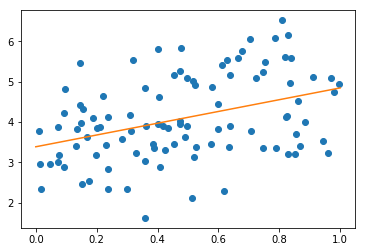

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neural_network import MLPRegressor
import sklearn


n = 100                  # Sample size equals 100
eps = np.random.randn(n) # Errors ~ N(0, 1)
m = 2                    # Slope equal to 2
x = np.random.random(n)  # x values uniformly distributed across [0,1]
b = 3                    # Y intercept equal to 3

y = m * x + b + eps # Generate the y data

# Estimate the model with linregress
(a_s, b_s, r, tt, stderr) = stats.linregress(x, y)

# Print estimated coefficients
print(a_s) # m
print(b_s) # b

# Setup predicted x and y values to plot
x_pred = np.linspace(0,1,100)
y_pred = a_s*x_pred+b_s

# We can estimate this model with 
plt.plot(x, y, 'o')
plt.plot(x_pred, y_pred)
plt.show()

Parameters (m and b) in this model are estimated via least squares, meaning that the sum of the squared errors (the vertical distance between an observation and the estimated mean) are minimized. If this indeed is the true model, least squares in the minimum variance unbiased estimator (UMVUE) of the true mean. But, if we misspecify the model, we might have large differences between the true model and our estimated model. For instance, consider the data being generated from a different model (a quadratic model in this case):

16.766943056615712
-8.522949330103067


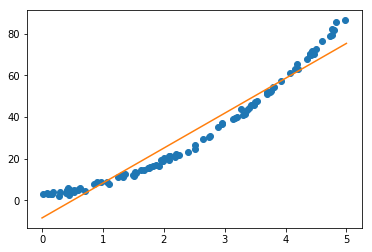

In [6]:
n = 100 # Sample size
eps = np.random.randn(n) # Errors ~ N(0, 1)
m = 2
l = 3
x = 5 *np.random.random(n) # x values uniformly distributed across [0,1]
b = 3
y = m * x + l * x**2 + b + eps

(a_s, b_s, r, tt, stderr) = stats.linregress(x, y)

print(a_s) # m
print(b_s) # b

x_pred = np.linspace(0,5,100)
y_pred = a_s*x_pred+b_s

# We can estimate this model with 
plt.plot(x, y, 'o')
plt.plot(x_pred, y_pred)
plt.show()

Thus, when we fit a linear regression model, it is important that we get an adequate representation of the functional form of the model. We could still fit this data with a linear regression model. For example we could estimate the model:

$$ y = \beta_0 + \beta_1 x + \beta_2 x^2 + \epsilon $$

and obtain an unbiased estimate of the true mean. This is second order univariate polynomial regression model and is still a linear model (it is **linear in the model terms**, i.e. it is linear in it's functional form).

A linear regression model may be a function of multiple variables. In general a simple linear regression model with $p$ variables might have the form:

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p + \epsilon $$

Instead of the one-dimensional fitted line as in the preceding examples, the estimated mean will be a p-dimensional surface. However, note that our assumption of linearity might be somewhat restricting, as we can only estimate models that can be approximated by polynomials. This is where neural networks will have an advantage, as they are a class of statistical models with a great deal of flexibility in their functional form.

## Neural Networks

A neural network can be considered as a nonparametric and nonlinear estimator of a function. It will have a great deal more flexibility in form than our linear regression model we have seen previously. 

### A nonlinear data generating process

Let us consider the following true data generating process:

$$ y = \theta_1 - \theta_2 exp( - exp(\theta_3 + \theta_4 log(x))) + \epsilon$$

With $\theta_1 = 80$, $\theta_2 = 71$, $\theta_3 = -10$, $\theta_4 = 2.4$ and $\epsilon \sim N(0, \sigma^2)$ and $\sigma = 2$. This is an example of a Weibull model used in [this book](https://link.springer.com/book/10.1007%2Fb97288) to model pasture regrowth. If we were equiped with this functional form and interested specifically in the values of these parameters, we could estimate these parameters via nonlinear least squares in a similar fashion of our previous linear regression model. For instance, estimating these parameters may have specific biological meaning to this pasture regrowth system. However, if we are merely interested in a model that predicts the mean well, we merely need a function that fits the data well. A neural network model will predict the mean well, but will not have a functional form amenable to such interpretation. 

Let's take a look at the data:


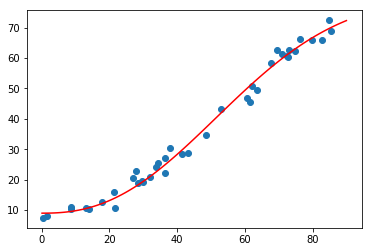

In [7]:
class nonlinear():
    """
    A Nonlinear Model Class: 
    params: theta_1 - theta_4
    param: sigma - Standard deviation
    param: n - sample size
    param: x_min, x_max
    function: simulate function
    """

    def __init__(self, n=40, sigma=2, theta_1=80, theta_2=71, theta_3=-10, theta_4=2.4, x_min=0.1, x_max=90):
        self.n = n
        self.sigma = sigma
        self.theta_1 = theta_1
        self.theta_2 = theta_2
        self.theta_3 = theta_3
        self.theta_4 = theta_4
        self.x_min = x_min
        self.x_max = x_max
        #self.df = self.simulate()

    def simulate(self, sample_size = 40):
        self.x = sorted(np.random.uniform(self.x_min, self.x_max, sample_size))
        self.y = self.theta_1 - self.theta_2 * np.exp(
            -np.exp(self.theta_3 + self.theta_4 * np.log(self.x))) + np.random.normal(0, self.sigma, sample_size)

    def plot(self):
        lin_x = np.linspace(self.x_min, self.x_max, 100)
        lin_y = self.theta_1 - self.theta_2 * np.exp(-np.exp(self.theta_3 + self.theta_4 * np.log(lin_x)))
        plt.scatter(self.x, self.y)
        plt.plot(lin_x, lin_y, color = 'red')
        plt.show()
        
nonlinear_model = nonlinear()
nonlinear_model.simulate()
nonlinear_model.plot()

Ok. Now that we are equiped with a nonlinear data generating process, we want to estimate it with a neural network. So what exactly is a neural network?

### Neural Networks

A neural network models a response as a linear combination nonlinear 'activation' functions. Specifically, a simple single layer neural network has the form:

\begin{align*}
y &= \beta_0 + \sum_{i=1}^{k} \beta_k * Z_m \\
&= \beta_0 + \sum_{i=1}^{k} \beta_k * \sigma( \alpha_{0p} + \sum_{j = 1}^p \alpha_j x_p) \\
\end{align*} 

where $\beta_0, \dots \beta_k$ and $\alpha_0, \dots, \alpha_j$ are model parameters and $\sigma$ is an 'activation' function.

If we stare at this function long enough, we will realize that indeed a neural network is simply a nonlinear model that is a linear combination of nonlinear functions of linear combinations (the sum parts of the model). 

The activation function has a special task in the above equation and it is to for the 'neuron' to 'activate' when the linear combination results in a value large or small enough. Let's take a look at the hyperbolic tangent activation function:

![image](./images/activation_ex.png)

We see that the value will gets close to -1 or 1 as the input gets small or large enough.

Ok. So that's the functional form of a neural network. Where is the network you might ask? It is simply a way to visualize the functional form of this model.

![image](./images/nnet_ex.png)

Ok. So now that we understand what a neural network is a bit more, let's build one with scikit-learn.

In [8]:
def build_neural_net(simulated_data):
  """
  Function to run fitting a keras model
  """

  # Alias simulated data
  X = simulated_data.x
  y = simulated_data.y
  # Print Training Time
  clf = MLPRegressor(
        activation='logistic', alpha=0, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(100,), learning_rate='invscaling',
        learning_rate_init=0.001, max_iter=10000, momentum=0.99,
        nesterovs_momentum=True, power_t=0.5,  random_state=1,
        shuffle=True, solver='lbfgs', tol=0.001, validation_fraction=0.0,
        verbose=False, warm_start=True
    )
  return clf
X = nonlinear_model.x
y = nonlinear_model.y
clf = build_neural_net(nonlinear_model)
clf.fit(np.array(X).reshape((40,1)), y)
x_pred = np.arange(0,90, .01).reshape((9000, 1))
preds = clf.predict(x_pred)




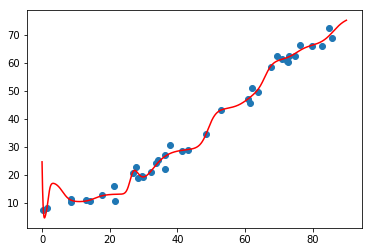

In [9]:
plt.scatter(X, y)
plt.plot(x_pred, preds, color = 'red')
plt.show()

Notice that although we model fits the data fairly well, it may not generalize well to unseen data. As we did in the workshop where we used tree depth to control smoothing and cross validation to choose maximum tree depth, we can do a similar process with neural networks. However, in this case, we will use L2 regularizatioon, which controls the size of the coefficient vector. 


In [14]:

def build_neural_net(simulated_data):
  """
  Function to run fitting a keras model
  """

  # Alias simulated data
  X = simulated_data.x
  y = simulated_data.y
  # Print Training Time
  clf = MLPRegressor(
    activation='logistic', alpha=12.4, batch_size='auto', beta_1=0.9,
    beta_2=0.999, early_stopping=False, epsilon=1e-08,
    hidden_layer_sizes=(100,), learning_rate='invscaling',
    learning_rate_init=0.001, max_iter=10000, momentum=0.99,
    nesterovs_momentum=True, power_t=0.5,  random_state=1,
    shuffle=True, solver='lbfgs', tol=0.001, validation_fraction=0.0,
    verbose=False, warm_start=True
    )
  return clf
X = nonlinear_model.x
y = nonlinear_model.y
clf = build_neural_net(nonlinear_model)
clf.fit(np.array(X).reshape((40,1)), y)
x_pred = np.arange(0,90, .01).reshape((9000, 1))
preds = clf.predict(x_pred)


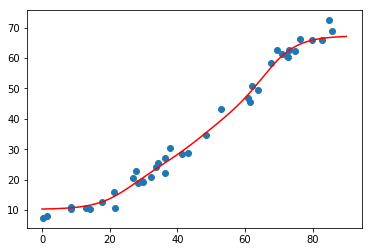

In [15]:
plt.scatter(X, y)
plt.plot(x_pred, preds, color = 'red')
plt.show()

Notice that the function is much smoother and closer to the ground truth. We won't go through a rigorous tuning of this model, which would involve using cross-validation for the optimal choice of a large number of tunable parameters. Instead, we will briefly describe some of these tuning parameters and let you all play around with the parameters of a neural network to understand what these tunable parameters will do for our model. 

First, there are a number of choices relating to parameters of the algorithm used to estimate the model. Rather than being able to solve for coefficients via least squares as in the linear regression case, we will estimate the model with  another process that won't necessarily return the optimal solution. These parameters control convergence of a given algorithm. For instance, in the above example, the 'lfbgs' method was used to estimate the model, and the following parameters are for the algorithm used:

- batch_size
- beta_1
- beta_2
- early_stopping
- epsilon
- learning_rate
- learning_rate_init
- nesterovs_momentum
- power_t
- shuffle
- solver
- tol
- validation_fraction
- warm_start

Indeed, most of the parameters being used relate to the estimation process. Other's control the functional form of the model:

- activation
- hidden_layer_size
- alpha

# Activity

In the following activity, we will play with the the parameters of the nueral network classifier to classify the make_moons and make_circles and linearly seperable datasets. Look at the documentation for the [MLPClassifier function](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) to choose and play around with the parameters of the neural network to get an idea on the effect of different parameters. Once you're happy with your tuned neural network, continue this exploration by heading over to this [neural network playground](https://playground.tensorflow.org/) from tensorflow.

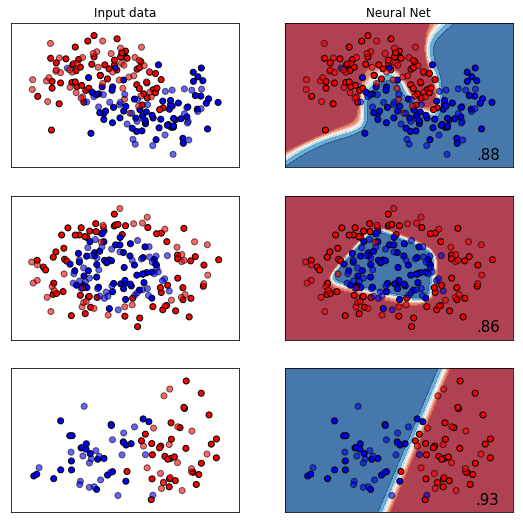

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier


h = .02  # step size in the mesh

names = ["Neural Net"]

classifiers = [
 
    MLPClassifier(
        activation='logistic', alpha=0.012, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(7,), learning_rate='adaptive',
        learning_rate_init=0.001, max_iter=100, momentum=0.99,
        nesterovs_momentum=True, power_t=0.5,  random_state=1,
        shuffle=True, solver='lbfgs', tol=0.001, validation_fraction=0.0,
        verbose=False, warm_start=True
                 )]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(n_samples = 200, noise=0.3, random_state=0),
            make_circles(n_samples = 200, noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(9, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

#plt.tight_layout()
plt.show()